reference: https://medium.com/raposa-technologies/how-to-build-your-first-mean-reversion-trading-strategy-in-python-8c9d4813ee40

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [5]:
# https://medium.com/raposa-technologies/backtest-your-first-strategy-in-python-88f663aee95e
def getStratStats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate) \
        / sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (buy_hold_strat['annual_returns'] - risk_free_rate) \
        / buy_hold_strat['annual_volatility']
    
    # Max Drawdown
    _strat_dd = data['strat_peak'] - data['strat_cum_returns']
    _buy_hold_dd = data['peak'] - data['cum_returns']
    sma_strat['max_drawdown'] = _strat_dd.max()
    buy_hold_strat['max_drawdown'] = _buy_hold_dd.max()
    
    # Max Drawdown Duration
    strat_dd = _strat_dd[_strat_dd==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days, 
        (_strat_dd.index[-1] - strat_dd.index[-1]).days])
    
    buy_hold_dd = _buy_hold_dd[_buy_hold_dd==0]
    buy_hold_diff = buy_hold_dd.index[1:] - buy_hold_dd.index[:-1]
    buy_hold_days = buy_hold_diff.map(lambda x: x.days).values
    buy_hold_days = np.hstack([buy_hold_days,
        (_buy_hold_dd.index[-1] - buy_hold_dd.index[-1]).days])
    sma_strat['max_drawdown_duration'] = strat_dd_days.max()
    buy_hold_strat['max_drawdown_duration'] = buy_hold_days.max()
    
    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}
    
    return stats_dict

## strat 1
we’ll look at the SMA and see if the price is too high or low compared to the SMA. If the price is too low, we’ll buy it with the expectation that the price will go higher, towards the moving average. If it’s over extended to the upside, then we sell or go short, again with the expectation that the price is going to drop in the near term.

In [7]:
def SMAMeanReversion(ticker, sma, threshold, shorts=False,    start_date='2000-01-01', end_date='2021-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(data['extension']<-threshold,
        1, data['position'])
    if shorts:
        data['position'] = np.where(
            data['extension']>threshold, -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01,
        0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * \
        data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * \
        data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns']  = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

In [8]:
ticker = 'AAL'
SMA = 50
threshold = 0.1
shorts = False
data = SMAMeanReversion(ticker, SMA, threshold, shorts)
stats_dict = getStratStats(data)
df_stats = pd.DataFrame(stats_dict).round(3)
df_stats

,strat_stats,base_stats
tot_returns,0.689,-0.407
annual_returns,0.033,-0.032
annual_volatility,0.529,0.675
sharpe_ratio,0.025,-0.077
max_drawdown,1.467,3.170
max_drawdown_duration,2790.000,5515.000


In [10]:
def plots(data):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(3, figsize=(10, 8), sharex=True)
    long = data.loc[data['position']==1]['Close']
    ax[0].plot(data['Close'], label='Price', linestyle=':', color=colors[1])
    ax[0].plot(data['SMA'], label='SMA', linestyle='--', color=colors[0])
    ax[0].scatter(long.index, long, label='Long', c=colors[2])
    ax[0].legend(bbox_to_anchor=[1, 0.75])
    ax[0].set_ylabel('Price ($)')
    ax[0].set_title(f'{ticker} Price and Positions with {SMA}-Day Moving Average')
    ax[1].plot(data['extension']*100, label='Extension', color=colors[0])
    ax[1].axhline(threshold*100, linestyle='--', color=colors[1])
    ax[1].axhline(-threshold*100, label='Threshold', linestyle='--', color=colors[1])
    ax[1].axhline(0, label='Neutral', linestyle=':', color='k')
    ax[1].set_title('Price Extension and Buy/Sell Thresholds')
    ax[1].set_ylabel(f'Extension (%)')
    ax[1].legend(bbox_to_anchor=[1, 0.75])
    ax[2].plot(data['position'])
    ax[2].set_xlabel('Date')
    ax[2].set_title('Position')
    ax[2].set_yticks([-1, 0, 1])
    ax[2].set_yticklabels(['Short', 'Neutral', 'Long'])
    plt.tight_layout()
    plt.show()

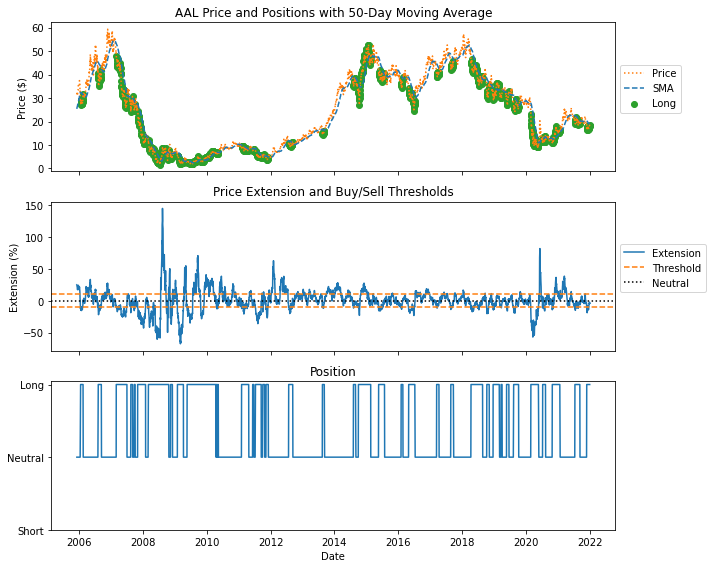

In [11]:
plots(SMAMeanReversion(ticker, SMA, threshold, shorts))